# Data Set Creation Notebook

This notebook creates the composite data set used in the Geocomputation module. You are welcome to add additional data sets for the purposes of the final assessment in the module if you so wish.

In [1]:
# Needed on a Mac
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import requests
import pandas as pd
import geopandas as gpd

In [3]:
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

import zipfile
def extract_all(file_path):
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall('.')
    zip_ref.close()

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))
    
def compress_all(srcdir, name):
    zipf = zipfile.ZipFile(name + '.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir(srcdir, zipf)
    zipf.close()

## London

Useful for filtering down the data sets that we've downloaded from OSOpen.

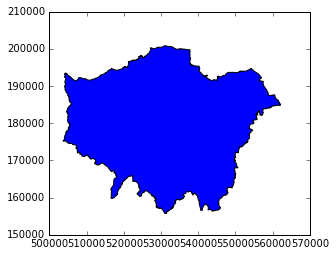

In [4]:
extract_all(os.path.join('Data','London.zip'))
ldn = gpd.read_file(os.path.join('London','London.shp'))
ldn.crs = {'init': u'epsg:27700'}
ldn.plot()

## Lower Super Output Area Data

Downloaded from the [London Data Store](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london), with the Output Area shapefile extracted and re-compressed to save space on GitHub. 

In [5]:
# Extract Output Areas
extract_all(os.path.join('Data','LSOA.zip'))
lsoa = gpd.read_file(os.path.join('LSOA','LSOA_2011_London_gen_MHW.shp'))
lsoa.crs = {'init': u'epsg:27700'}

# Stash a copy of original geometry and the centroids
# since we'll need both again
#lsoa['outlines']  = lsoa.geometry
#lsoa['centroids'] = lsoa.geometry.centroid

In [6]:
# Notice the range of geographies to which we can now join:
# LSOA, MSOA, LA, and Region
# We've also got some very simple, basic measures such as
# population density, usual residents, and average household
# size.
lsoa.head(2)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.0919998939 182011.23, 532162...."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.8130000263 181786.891000028, ..."


## OS Open Data Sets

You can download the following data sets from the [OS Open Download Page](https://www.ordnancesurvey.co.uk/opendatadownload/products.html). This step cannot easily be automated, sorry.

* OS Open Map - Local - ESRI SHAPE - TQ
* OS VectorMap District - ESRI Shape - TQ
* OS Open Greenspace - ESRI SHAPE - TQ

For each of these data sets, we have filtered out everything that is _not_ within the GLA boundary. This reduces file size significantly and can be done fairly quickly within QGIS.

### Open Greenspace

In [7]:
#extract_all(os.path.join('Data','opgrsp_essh_tq.zip'))

grsp = gpd.read_file(os.path.join('OS Open Greenspace (ESRI Shape File) TQ','data','TQ_GreenspaceSite.shp'))
grsp.crs = {'init': u'epsg:27700'}
print("Raw file has " + str(grsp.shape[0]) + " rows.")

grsp = grsp[grsp.function=='Public Park Or Garden']
grsp = gpd.sjoin(grsp, ldn, how="inner", op='within')

print("Filtered down to " + str(grsp.shape[0]) + " rows.")

ensure_dir(os.path.join('Greenspace','GLA Greenspace.shp'))
grsp.to_file(os.path.join('Greenspace','GLA Greenspace.shp'))

compress_all('Greenspace',os.path.join('Data','Greenspace'))

Raw file has 18023 rows.


/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:1880: RuntimeWarning: invalid value encountered in find_contains (vectorized)
  outputs = ufunc(*inputs)


Filtered down to 989 rows.


In [8]:
print("Starting buffer and dissolve...")
grspd = grsp.simplify(5).buffer(5).unary_union

print("Calculating intersection...")
lsoa_overlay = lsoa['geometry'].intersection(grspd)

print("Saving results to LSOA data frame...")
lsoa['Area that is Designated Greenspace'] = pd.Series(lsoa_overlay.geometry.area, index=lsoa.index)

Starting buffer and dissolve...
Calculating intersection...
Saving results to LSOA data frame...


## A- and M-class Roads

In [9]:
extract_all(os.path.join('Data','opmplc_essh_tq.zip'))

rds = gpd.read_file(os.path.join('OS OpenMap Local (ESRI Shape File) TQ','data','TQ_Road.shp'))
rds.crs = {'init': u'epsg:27700'}
print("Raw file has " + str(rds.shape[0]) + " rows.")

rds = rds[rds.CLASSIFICA.isin(['A Road','A Road, Collapsed Dual Carriageway','Motorway','Motorway, Collapsed Dual Carriageway'])]
rds = gpd.sjoin(rds, ldn, how="inner", op='within')

print("Filtered down to " + str(rds.shape[0]) + " rows.")

ensure_dir(os.path.join('Roads','Roads.shp'))
rds.to_file(os.path.join('Roads','Roads.shp'))

compress_all('Roads',os.path.join('Data','Roads'))

Raw file has 375482 rows.
Filtered down to 17988 rows.


In [10]:
buffer_d = 250

print("Starting buffer and dissolve...")
impact = rds.simplify(25).buffer(buffer_d).unary_union

print("Calculating intersection...")
lsoa_overlay = lsoa['geometry'].intersection(impact)

print("Saving results to LSOA data frame...")
lsoa['Area within ' + str(buffer_d) + 'm of M or A Roads'] = pd.Series(lsoa_overlay.geometry.area, index=lsoa.index)

Starting buffer and dissolve...
Calculating intersection...
Saving results to LSOA data frame...


In [11]:
ensure_dir(os.path.join('Physical','Physical.shp'))
lsoa.to_file(os.path.join('Physical','Physical.shp'))

## KS402EW - Tenure

In [12]:
tenure = pd.read_excel(os.path.join('Data','KS402EW - Tenure.xlsx'), header=8)
tenure['lsoacd'], tenure['lsoanm'] = tenure['2011 super output area - lower layer'].str.split(' : ').str
tenure.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
tenure.sample(2)

,Owned,Shared ownership (part owned and part rented),Social rented,Private rented,Living rent free,lsoacd
4393,290.0,1.0,23.0,245.0,8.0,E01003767
435,177.0,47.0,313.0,281.0,28.0,E01001979


In [13]:
lsoa = pd.merge(lsoa, tenure, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)
lsoa.sample(2)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,HHOLDS,AVHHOLDSZ,geometry,greenspace,hvy_roads,Owned,Shared ownership (part owned and part rented),Social rented,Private rented,Living rent free
3535,E01003616,Newham 012A,E02000725,Newham 012,E09000025,Newham,E12000007,London,1650,1650,...,658,2.5,"POLYGON ((538860.3610000833 185251.882999958, ...",0.0,58121.300583,153.0,12.0,226.0,257.0,10.0
4704,E01032788,Hammersmith and Fulham 023D,E02000394,Hammersmith and Fulham 023,E09000013,Hammersmith and Fulham,E12000007,London,1106,1099,...,496,2.2,"POLYGON ((526264.7460001282 176281.5390001138,...",0.0,33795.339915,170.0,3.0,177.0,142.0,4.0


## KS403EW - Rooms, bedrooms and central heating

In [14]:
rooms = pd.read_excel(os.path.join('Data','KS403EW - Rooms, bedrooms and central heating.xlsx'), header=8)
rooms['lsoacd'], rooms['lsoanm'] = rooms['2011 super output area - lower layer'].str.split(' : ').str
rooms.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
rooms.sample(2)
lsoa = pd.merge(lsoa, rooms, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,hvy_roads,Owned,Shared ownership (part owned and part rented),Social rented,Private rented,Living rent free,Occupancy rating (rooms) of -1 or less,Occupancy rating (bedrooms) of -1 or less,Average number of rooms per household,Average number of bedrooms per household
2197,E01002248,Havering 017C,E02000480,Havering 017,E09000016,Havering,E12000007,London,1397,1395,...,158819.317353,371.0,0.0,127.0,92.0,2.0,56.0,41.0,4.8,2.5
115,E01000119,Barnet 009C,E02000032,Barnet 009,E09000003,Barnet,E12000007,London,1680,1680,...,91906.985226,509.0,1.0,24.0,64.0,9.0,36.0,32.0,6.0,3.2


## KS201EW - Ethnic group

In [15]:
ethnicity = pd.read_excel(os.path.join('Data','KS201EW - Ethnic group.xlsx'), header=8)
ethnicity['lsoacd'], ethnicity['lsoanm'] = ethnicity['2011 super output area - lower layer'].str.split(' : ').str
ethnicity.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
ethnicity.sample(2)
lsoa = pd.merge(lsoa, ethnicity, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Living rent free,Occupancy rating (rooms) of -1 or less,Occupancy rating (bedrooms) of -1 or less,Average number of rooms per household,Average number of bedrooms per household,White,Mixed/multiple ethnic groups,Asian/Asian British,Black/African/Caribbean/Black British,Other ethnic group
1249,E01001269,Ealing 001A,E02000238,Ealing 001,E09000009,Ealing,E12000007,London,1983,1983,...,2.0,135.0,92.0,5.0,2.8,986.0,69.0,593.0,224.0,111.0
1388,E01001409,Enfield 005B,E02000281,Enfield 005,E09000010,Enfield,E12000007,London,1889,1881,...,10.0,205.0,94.0,4.2,2.2,1162.0,116.0,223.0,307.0,81.0


## AirBnB Listings

We'll just get the smaller data set since we have to summarise anyway.

Data frame shape: (53904, 16)


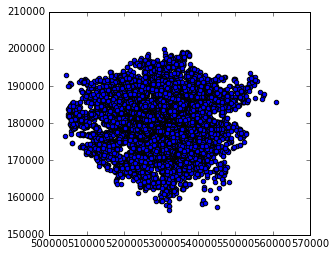

In [44]:
from shapely.geometry import Point

airbnb = pd.read_csv(
    'http://data.insideairbnb.com/united-kingdom/england/london/2017-03-04/visualisations/listings.csv',
    low_memory=False) # The 'low memory' option means pandas doesn't guess data types
print("Data frame shape: " + str(df.shape)) # What is the shape of the data?

geometry = [Point(xy) for xy in zip(airbnb.longitude, airbnb.latitude)]
airbnb.drop(['longitude', 'latitude'], axis=1, inplace=True)
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(airbnb, crs=crs, geometry=geometry)
geo_df = geo_df.to_crs({'init': 'epsg:27700'})
geo_df.plot()

In [47]:
lsoa2 = gpd.read_file(os.path.join('LSOA','LSOA_2011_London_gen_MHW.shp'))
lsoa2.crs = {'init': u'epsg:27700'}

bnb = gpd.sjoin(geo_df, lsoa2, how="inner", op='within')
bnb.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,...,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ
0,15896822,Double room in newly refurbished flat,69018624,Dafina,NaN,Kingston upon Thames,Private room,23,7,1,...,E09000021,Kingston upon Thames,E12000007,London,2631,2375,256,47.3,1123,2.1
22,13577025,Entire 2 bed/1 sofabed newly refurbished apart...,45469611,Charlie,NaN,Kingston upon Thames,Entire home/apt,150,3,2,...,E09000021,Kingston upon Thames,E12000007,London,2631,2375,256,47.3,1123,2.1
42,14535520,Modern flat in Kingston,10407160,Andrew,NaN,Kingston upon Thames,Shared room,25,2,6,...,E09000021,Kingston upon Thames,E12000007,London,2631,2375,256,47.3,1123,2.1


In [52]:
bnb.columns[0:17]

Index([                            u'id',                           u'name',
                              u'host_id',                      u'host_name',
                  u'neighbourhood_group',                  u'neighbourhood',
                            u'room_type',                          u'price',
                       u'minimum_nights',              u'number_of_reviews',
                          u'last_review',              u'reviews_per_month',
       u'calculated_host_listings_count',               u'availability_365',
                             u'geometry',                    u'index_right',
                             u'LSOA11CD'],
      dtype='object')

In [ ]:
bnb = bnb[bnb.columns[0:17]]
bnb.drop('index_right', axis=1, inplace=True)

In [60]:
bnb.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,LSOA11CD
0,15896822,Double room in newly refurbished flat,69018624,Dafina,NaN,Kingston upon Thames,Private room,23,7,1,2016-12-03,0.32,1,61,POINT (517890.3426608781 169250.9032244062),E01002968
22,13577025,Entire 2 bed/1 sofabed newly refurbished apart...,45469611,Charlie,NaN,Kingston upon Thames,Entire home/apt,150,3,2,2017-01-03,0.30,2,87,POINT (517902.2206599751 169457.8831601905),E01002968
42,14535520,Modern flat in Kingston,10407160,Andrew,NaN,Kingston upon Thames,Shared room,25,2,6,2017-02-19,1.22,1,83,POINT (517838.0874002122 168926.8190679598),E01002968
82,10794498,Kingsize Bedroom in Great Flat,31551389,Anton,NaN,Kingston upon Thames,Private room,45,1,14,2016-10-26,1.14,1,77,POINT (518217.7206132917 169556.9401960188),E01002968
89,9339731,Yellow Sub lifeboat,48473937,Anthony,NaN,Kingston upon Thames,Shared room,60,1,0,NaN,NaN,1,365,POINT (517802.4854577596 169000.1591928671),E01002968
97,16040997,London,16057345,Judy,NaN,Kingston upon Thames,Entire home/apt,150,2,6,2017-01-28,2.43,1,308,POINT (517768.9000816804 169623.8862351987),E01002968
104,13021521,"6 MONTH RENTAL IN KINGSTON, BEAUTIFULLY APPOINTED",71897892,Linda,NaN,Kingston upon Thames,Entire home/apt,160,5,2,2016-07-30,0.27,1,0,POINT (517866.0157143786 169283.1376415993),E01002968
127,17275703,Cozy bed for female travellers,107782426,Anh,NaN,Kingston upon Thames,Shared room,15,1,1,2017-02-23,1.00,1,21,POINT (518277.6727618763 168928.7223448758),E01002968
160,14393265,In the heart of buzzy Kingston!,14622751,Alexia,NaN,Kingston upon Thames,Private room,40,1,5,2017-01-20,0.76,1,277,POINT (518289.4241965279 168967.3833958741),E01002968
163,15544357,2 double rooms Tudor flat in historical centre,35726991,Cherie,NaN,Kingston upon Thames,Entire home/apt,110,7,0,NaN,NaN,1,0,POINT (517787.2090167234 169244.0273084749),E01002968


In [ ]:
# Work out which hosts lists many properties and set multi-listing variable
#   then aggregate by multi-listing
# Count of room type by multi-listing
# Mean and median price of room type by multi-listing

In [56]:
bnbg = bnb.groupby(['LSOA11CD','Multiple Location Host'])

In [59]:
bnbg.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,LSOA11CD
0,15896822,Double room in newly refurbished flat,69018624,Dafina,NaN,Kingston upon Thames,Private room,23,7,1,2016-12-03,0.32,1,61,POINT (517890.3426608781 169250.9032244062),E01002968
22,13577025,Entire 2 bed/1 sofabed newly refurbished apart...,45469611,Charlie,NaN,Kingston upon Thames,Entire home/apt,150,3,2,2017-01-03,0.30,2,87,POINT (517902.2206599751 169457.8831601905),E01002968
1,4836957,Modern room 25m from Central London,18154504,Anas,NaN,Kingston upon Thames,Private room,50,1,15,2016-09-07,0.67,1,364,POINT (518972.7995264124 169436.97675451),E01002972
27,10085459,Warm modern flat in Kingston,15082436,Paolo & Lia,NaN,Kingston upon Thames,Entire home/apt,85,5,24,2017-02-18,1.68,1,21,POINT (518895.5885775421 169255.3418541058),E01002972
2,13355982,Lovely double bedroom in Kingston Upon Thames,75741819,Maria,NaN,Kingston upon Thames,Private room,24,1,2,2016-07-27,0.25,1,0,POINT (519254.0605487449 169929.6418766109),E01002935
60,5902097,Cosy flat in SW London,21799011,Chris,NaN,Kingston upon Thames,Entire home/apt,75,2,20,2017-02-21,0.93,2,352,POINT (519259.8053694759 170101.8547339618),E01002935
3,13472704,Double Room in North Kingston (Richmond Park),77078182,Hannah,NaN,Kingston upon Thames,Private room,50,2,0,NaN,NaN,1,0,POINT (518854.5845124729 169906.1239165709),E01002937
48,7515814,Relaxing Garden Apartment,26371060,Ana,NaN,Kingston upon Thames,Entire home/apt,59,2,47,2017-02-25,2.43,1,286,POINT (518573.0133017235 169658.1684718979),E01002937
4,17430865,family-friendly house,113972982,Jung Kyung,NaN,Kingston upon Thames,Private room,25,1,0,NaN,NaN,1,179,POINT (520054.1097189174 168661.4800590563),E01002973
118,11514072,Nice room close to central London,2216702,Elizabeth,NaN,Kingston upon Thames,Private room,25,1,9,2016-08-25,1.13,1,0,POINT (519968.7412996425 168564.1952576889),E01002973


In [ ]:
f = {'room_type':['sum'], 'price':['sum','mean','median']}
df.groupby('LSOA11CD').agg(f)

## Wrapping Up

Save the final output for use by students.

In [30]:
lsoa['Area'] = lsoa.geometry.area
lsoa.columns

Index([                                     u'LSOA11CD',
                                            u'LSOA11NM',
                                            u'MSOA11CD',
                                            u'MSOA11NM',
                                             u'LAD11CD',
                                             u'LAD11NM',
                                             u'RGN11CD',
                                             u'RGN11NM',
                                            u'USUALRES',
                                            u'HHOLDRES',
                                           u'COMESTRES',
                                              u'POPDEN',
                                              u'HHOLDS',
                                           u'AVHHOLDSZ',
                                            u'geometry',
                                          u'greenspace',
                                           u'hvy_roads',
                               

In [32]:
lsoadf.sample(3)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Occupancy rating (rooms) of -1 or less,Occupancy rating (bedrooms) of -1 or less,Average number of rooms per household,Average number of bedrooms per household,White,Mixed/multiple ethnic groups,Asian/Asian British,Black/African/Caribbean/Black British,Other ethnic group,Area
1064,E01001083,Croydon 003A,E02000196,Croydon 003,E09000008,Croydon,E12000007,London,1609,1609,...,44.0,30.0,6.3,3.5,643.0,87.0,541.0,314.0,24.0,321651.060501
496,E01000504,Brent 018A,E02000110,Brent 018,E09000005,Brent,E12000007,London,1676,1676,...,186.0,101.0,4.5,2.4,993.0,117.0,226.0,234.0,106.0,147773.783669
3314,E01003388,Merton 013B,E02000701,Merton 013,E09000024,Merton,E12000007,London,1439,1439,...,81.0,52.0,4.7,2.5,645.0,97.0,337.0,329.0,31.0,145555.410810


In [31]:
lsoadf = pd.DataFrame(lsoa.drop(['geometry'], axis=1))
lsoadf.to_csv(os.path.join('Data','LSOA Data.csv.gz'), compression='gzip')

In [33]:
ensure_dir(os.path.join('Final','LSOA Data.shp'))
lsoa.to_file(os.path.join('Final','LSOA Data.shp'))